In [35]:
%matplotlib widget
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import time

import pclpy
from pclpy import pcl

In [9]:
pcdfile = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_100.pcd')

pc = pcl.PointCloud.PointXYZ()
reader = pcl.io.PCDReader()
reader.read(pcdfile, pc)

0

In [20]:
rg = pcl.segmentation.RegionGrowing.PointXYZ_Normal()

rg.setInputCloud(pc)
normals_estimation = pcl.features.NormalEstimationOMP.PointXYZ_Normal()
normals_estimation.setInputCloud(pc)
normals = pcl.PointCloud.Normal()
normals_estimation.setRadiusSearch(0.35)
normals_estimation.compute(normals)
rg.setInputNormals(normals)

rg.setMaxClusterSize(1000000)
rg.setMinClusterSize(10)
rg.setNumberOfNeighbours(15)
rg.setSmoothnessThreshold(5 / 180 * math.pi)
rg.setCurvatureThreshold(5)
rg.setResidualThreshold(1)
start_time = time.time()
clusters = pcl.vectors.PointIndices()
rg.extract(clusters)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.012003660202026367


Text(0.5, 0.5, 'Y')

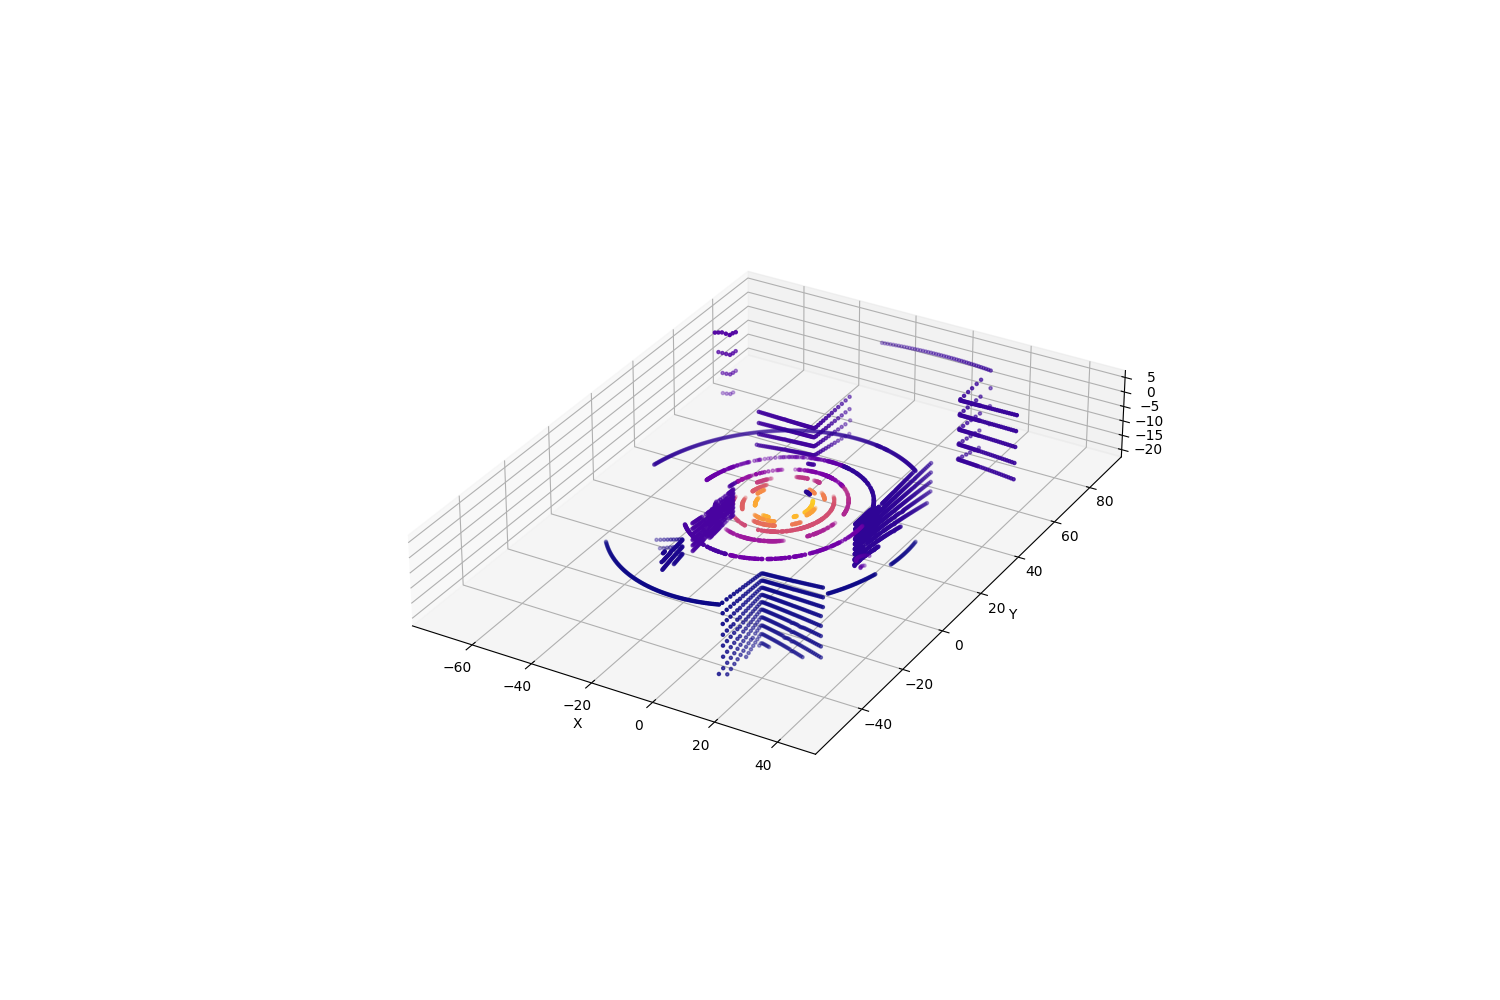

In [37]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, c in enumerate(clusters):
    idx = c.indices
    ax.scatter3D(pc.xyz[idx,0], pc.xyz[idx,1], pc.xyz[idx,2], color=colors[i,:], marker='.')  
ax.set_box_aspect((np.ptp(pc.xyz[:,0]), np.ptp(pc.xyz[:,1]), np.ptp(pc.xyz[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")